# System Recommendation - Good Books 10k

## Tentang Dataset dan Submission

Dataset ini berisi peringkat untuk sepuluh ribu buku populer. Secara umum, ada 100 ulasan untuk setiap buku, meskipun beberapa buku hanya memiliki sedikit ulasan.
Submission ini adalah sistem untuk merekomendasikan buku kepada user dengan fitur yang sudah ditentukan untuk `Content-Based` yaitu `title` dan `authors`, sedangkan untuk `Collaborative` menggunakan fitur `book_id` dan `rating_id`

## 1. Import Libraries

Pada tahapan ini akan di import semua library yang digunakan dalam project system rekomendasi ini.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import tensorflow as tenflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

## 2. Data Understanding

### 2.1 Data Loading

Pada tahapan ini, dataset `books` dan `ratings` dimuat untuk selanjutnya akan dilakukan pembangunan sistem rekomendasi.

In [32]:
books = pd.read_csv('data/books.csv', encoding = "ISO-8859-1")
ratings = pd.read_csv('data/ratings.csv')

Menampilkan 5 data teratas dan terbawah untuk dataset `books`

In [33]:
books

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


Menampilkan 5 data teratas dan terbawah untuk dataset `ratings`

In [34]:
ratings

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


Potongan kode ini untuk menampilkan informasi jumlah data pada dataset `books`, dan juga informasi jumlah data pada dataset `ratings`

In [35]:
print(f'Jumlah data buku adalah --> {books["book_id"].nunique()}')

print('-'*80)

print(f'Jumlah data rating keseluruhan --> {len(ratings)}')
print(f'Jumlah pengguna yang memberikan rating pada buku --> {ratings["user_id"].nunique()}')
print(f'Jumlah buku yang memiliki rating --> {ratings["book_id"].nunique()}')

Jumlah data buku adalah --> 10000
--------------------------------------------------------------------------------
Jumlah data rating keseluruhan --> 981756
Jumlah pengguna yang memberikan rating pada buku --> 53424
Jumlah buku yang memiliki rating --> 10000


### 2.2 Univarite Analysis

Potongan code ini untuk menampilkan jumlah baris dan kolom, beserta menampilkan kolom-kolom yang ada pada dataset `books`

#### 2.2.1 Books

In [36]:
print("Books shape:", books.shape)
print("Books columns:", books.columns)

Books shape: (10000, 23)
Books columns: Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')


Potongan code dibawah berguna untuk menampilkan informasi dataset secara lengkap, mulai dari kolom, hingga tipe data

In [37]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

Menampilkan jumlah data yang hilang untuk setiap kolom pada dataset `books`

In [38]:
books.isnull().sum()

,0
id,0
book_id,0
best_book_id,0
work_id,0
books_count,0
isbn,700
isbn13,585
authors,0
original_publication_year,21
original_title,585


Melihat Informasi statistik dari dataset `books`

In [39]:
books.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,10000.0,5.000500e+03,2.886896e+03,1.000000e+00,2.500750e+03,5.000500e+03,7.500250e+03,1.000000e+04
book_id,10000.0,5.264697e+06,7.575462e+06,1.000000e+00,4.627575e+04,3.949655e+05,9.382225e+06,3.328864e+07
best_book_id,10000.0,5.471214e+06,7.827330e+06,1.000000e+00,4.791175e+04,4.251235e+05,9.636112e+06,3.553423e+07
work_id,10000.0,8.646183e+06,1.175106e+07,8.700000e+01,1.008841e+06,2.719524e+06,1.451775e+07,5.639960e+07
books_count,10000.0,7.571270e+01,1.704707e+02,1.000000e+00,2.300000e+01,4.000000e+01,6.700000e+01,3.455000e+03
isbn13,9415.0,9.755044e+12,4.428619e+11,1.951703e+08,9.780316e+12,9.780452e+12,9.780831e+12,9.790008e+12
original_publication_year,9979.0,1.981988e+03,1.525767e+02,-1.750000e+03,1.990000e+03,2.004000e+03,2.011000e+03,2.017000e+03
average_rating,10000.0,4.002191e+00,2.544275e-01,2.470000e+00,3.850000e+00,4.020000e+00,4.180000e+00,4.820000e+00
ratings_count,10000.0,5.400124e+04,1.573700e+05,2.716000e+03,1.356875e+04,2.115550e+04,4.105350e+04,4.780653e+06
work_ratings_count,10000.0,5.968732e+04,1.678038e+05,5.510000e+03,1.543875e+04,2.383250e+04,4.591500e+04,4.942365e+06


Menampilkan distribusi rating untuk setiap buku, terlihat mayoritas buku memiliki rating di angka 4

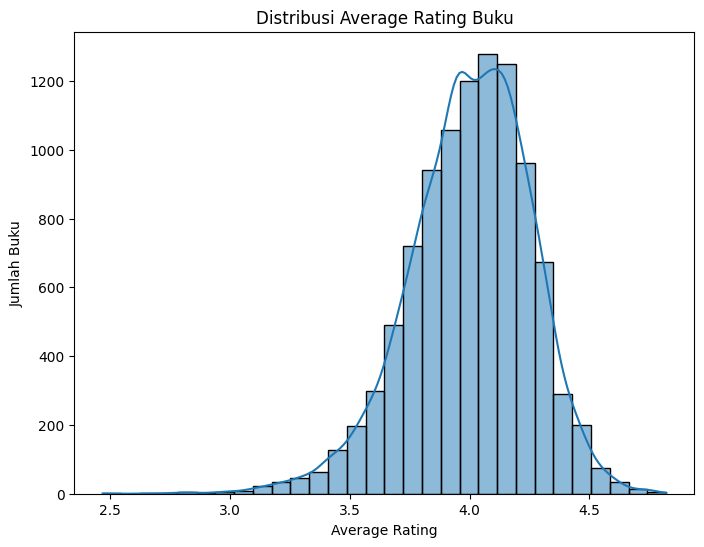

In [40]:
plt.figure(figsize=(8,6))
sns.histplot(books['average_rating'], bins=30, kde=True)
plt.title('Distribusi Average Rating Buku')
plt.xlabel('Average Rating')
plt.ylabel('Jumlah Buku')
plt.show()

Menampilkan 10 penulis dengan jumlah buku terbanyak yang sudah di tulis

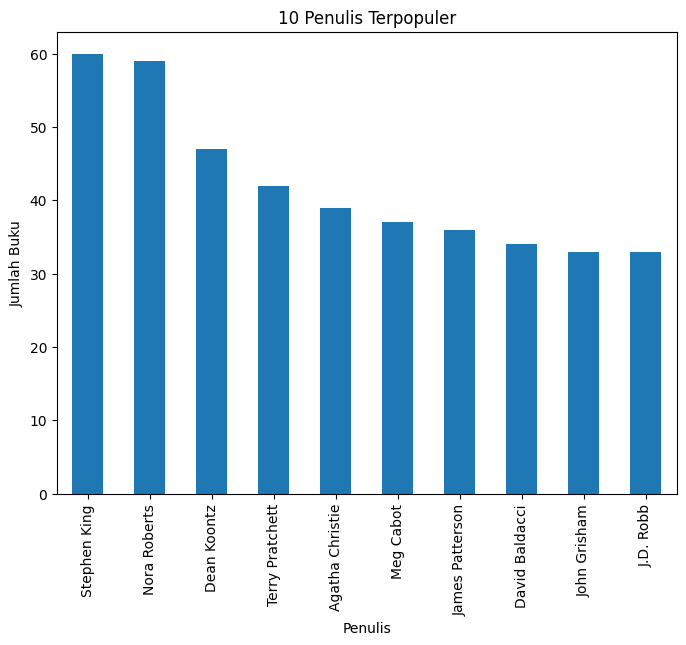

In [41]:
authors_count = books['authors'].value_counts()
plt.figure(figsize=(8,6))
authors_count.head(10).plot(kind='bar')
plt.title('10 Penulis Terpopuler')
plt.xlabel('Penulis')
plt.ylabel('Jumlah Buku')
plt.show()

#### 2.2.2 Ratings

Potongan code ini untuk menampilkan jumlah baris dan kolom, beserta menampilkan kolom-kolom yang ada pada dataset `ratings`

In [42]:
print("Ratings shape:", ratings.shape)
print("Ratings columns:", ratings.columns)

Ratings shape: (981756, 3)
Ratings columns: Index(['book_id', 'user_id', 'rating'], dtype='object')


Potongan code dibawah berguna untuk menampilkan informasi dataset secara lengkap, mulai dari kolom, hingga tipe data

In [43]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


Menampilkan jumlah data yang hilang untuk setiap kolom pada dataset `ratings`

In [44]:
ratings.isnull().sum()

,0
book_id,0
user_id,0
rating,0


Menampilkan jumlah data yang hilang untuk setiap kolom pada dataset `ratings`

In [45]:
ratings.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
book_id,981756.0,4943.275636,2873.207415,1.0,2457.0,4921.0,7414.0,10000.0
user_id,981756.0,25616.759933,15228.338826,1.0,12372.0,25077.0,38572.0,53424.0
rating,981756.0,3.856534,0.983941,1.0,3.0,4.0,5.0,5.0


Menampilkan distribusi rating yang diberikan oleh user, terlihat rating 4 memiliki nilai paling banyak dibanding rating lainnay

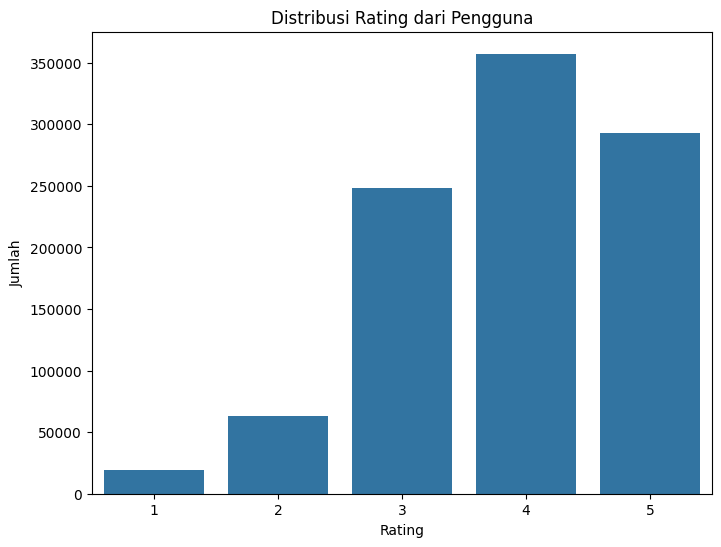

In [46]:
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribusi Rating dari Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Menampilkan informasi seberapa banyak user memberi rating untuk buku-buku, kebanyakan user hanya memberikan rating 1 s.d 5x saja

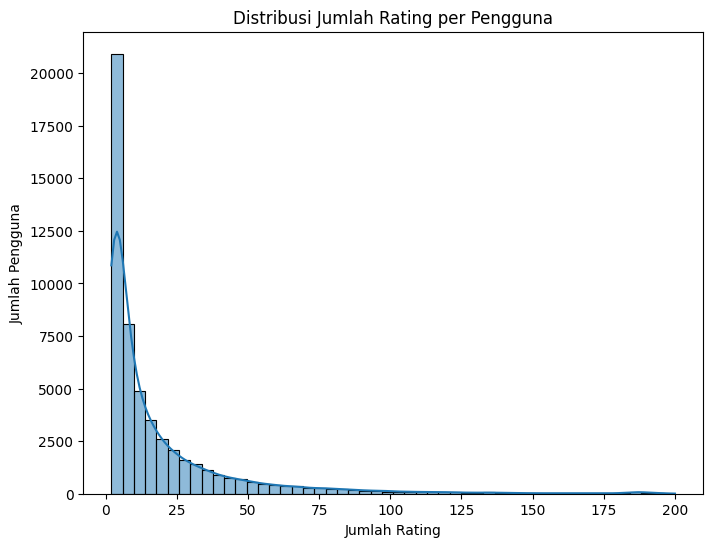

In [47]:
user_rating_count = ratings['user_id'].value_counts()
plt.figure(figsize=(8,6))
sns.histplot(user_rating_count, bins=50, kde=True)
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Pengguna')
plt.show()

## 3. Data Preparation

Pada tahapan pembersihan dataset `books` dan `ratings` dilakukan untuk memastikan data bersih sebelum dilakukan tahapan `modeling`

### 3.1 Books

Membersihkan dataset dengan menghapus kolom yang tidak relevan, mengisi data kosong pada `language_code` dengan mengisi modus, dan sebagainya.

In [48]:
books = books.dropna(subset=['original_title'])

books = books.drop(columns=['isbn', 'isbn13'])

books['original_publication_year'].fillna(books['original_publication_year'].median(), inplace=True)

books['language_code'] = books['language_code'].fillna(books['language_code'].mode()[0])

books['image_url'] = books['image_url'].fillna('No Image')

Menampilkan informasi dataset `books` setelah dilakukan pembersihan

In [49]:
print(books.isnull().sum())

id                           0
book_id                      0
best_book_id                 0
work_id                      0
books_count                  0
authors                      0
original_publication_year    0
original_title               0
title                        0
language_code                0
average_rating               0
ratings_count                0
work_ratings_count           0
work_text_reviews_count      0
ratings_1                    0
ratings_2                    0
ratings_3                    0
ratings_4                    0
ratings_5                    0
image_url                    0
small_image_url              0
dtype: int64


### 3.2 Ratings

Menormalisasi feature rating sehingga model deep learning dapat lebih efektif dalam mendeteksi pola, dan juga dapat mempercepat pelatihan.

In [53]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

ratings['rating_norm'] = (ratings['rating'] - min_rating) / (max_rating - min_rating)


Proses dibawah ini adalah mapping atau memetakan nilai unik dari kolom user_id dan book_id ke indeks numerik yang lebih sederhana. 

In [54]:
user_mapping = {id:i for i, id in enumerate(ratings['user_id'].unique())}
book_mapping = {id:i for i, id in enumerate(ratings['book_id'].unique())}

ratings['user'] = ratings['user_id'].map(user_mapping)
ratings['book'] = ratings['book_id'].map(book_mapping)

Memisahkan data dengan proporsi 80/10/10, dengan begini model dapat dilatih dengan data yang dicukup, dan dievalusasi, dan diuji menggunakan data yang terpisah dari data pelatihan

In [55]:
train_data, temp_data = train_test_split(ratings, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Jumlah data untuk pelatihan: {len(train_data)}")
print(f"Jumlah data untuk validasi: {len(validation_data)}")
print(f"Jumlah data untuk pengujian: {len(test_data)}")

Jumlah data untuk pelatihan: 785404
Jumlah data untuk validasi: 98176
Jumlah data untuk pengujian: 98176


In [56]:
X_train = [train_data['user_id'].values, train_data['book_id'].values]
y_train = train_data['rating_norm'].values

X_val = [validation_data['user_id'].values, validation_data['book_id'].values]
y_val = validation_data['rating_norm'].values

## 4. Modeling

### 4.1 Content-Based Filtering

Potongan code dibawah adalah menentukan fitur yang relevan untuk `modelling` pada `Content-Based`, yaitu fitur `title` dan `authors`, jadi rekomendasi akan diberikan berdasarkan `judul` dan `authors`. Sayangnya dataset ini tidak memiliki `genre`, yang mungkin akan lebih baik untuk model

In [57]:
books['title_authors'] = books['title'] + ' ' + books['authors']

indices = pd.Series(books.index, index=books['title'])

Melakukan vectorizer terhadap fitur yang sudah ditentukan sebelumnya, serta menghitung similarity menggunakan Cosine Similarity untuk menghitung seberapa mirip satu data dengan data lainnya.

In [58]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(books['title_authors'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Potongan code dibawah adalah fungsi untuk menghasilkan rekomendasi buku berdasarkan inputan dari user, dengan menampilkan 5 buku teratas dengan nilai similarity tertinggi

In [59]:
def book_recommendations(title, n=5):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]

    book_indices = [i[0] for i in sim_scores]

    return books.iloc[book_indices][['book_id', 'title', 'authors', 'original_publication_year', 'average_rating']]

rekomendasi = book_recommendations('The Hobbit', 5)
rekomendasi

,book_id,title,authors,original_publication_year,average_rating
963,30,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,1973.0,4.59
1128,1081560,"The History of the Hobbit, Part One: Mr. Baggins","John D. Rateliff, J.R.R. Tolkien",2007.0,3.81
2308,597790,The Children of HÃºrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee",2007.0,3.94
465,659469,The Hobbit: Graphic Novel,"Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sea...",1989.0,4.48
4975,7329,Unfinished Tales of NÃºmenor and Middle-Earth,"J.R.R. Tolkien, Christopher Tolkien",1980.0,3.93


### 4.2 Collaborative Filtering

Menyesun strukur model deep learning untuk pembangunan model pendekatan `collaborative-filtering`

In [60]:
embedding_size = 50

user_input = Input(shape=(1,), name='user_input')
book_input = Input(shape=(1,), name='book_input')

user_embedding = Embedding(
    input_dim=ratings['user_id'].nunique() + 1,
    output_dim=embedding_size,
    embeddings_regularizer=l2(1e-6)
)(user_input)

book_embedding = Embedding(
    input_dim=ratings['book_id'].nunique() + 1,
    output_dim=embedding_size,
    embeddings_regularizer=l2(1e-6)
)(book_input)

user_bias = Embedding(
    input_dim=ratings['user_id'].nunique() + 1,
    output_dim=1
)(user_input)

book_bias = Embedding(
    input_dim=ratings['book_id'].nunique() + 1,
    output_dim=1
)(book_input)

user_vec = Flatten()(user_embedding)
book_vec = Flatten()(book_embedding)

user_b = Flatten()(user_bias)
book_b = Flatten()(book_bias)

dot_product = Dot(axes=1)([user_vec, book_vec])
output = Add()([dot_product, user_b, book_b])

model = Model(inputs=[user_input, book_input], outputs=output)

model.compile(
    loss=tenflow.keras.losses.MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mean_absolute_error', "root_mean_squared_error"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │  2,671,250 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 50)     │    500,050 │ book_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 50)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 1)      │     53,425 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 1)      │     10,001 │ book_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1)         │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 1)         │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1)         │          0 │ dot_1[0][0],      │
│                     │                   │            │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,234,726 (12.34 MB)

 Trainable params: 3,234,726 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

Pembuatan `callbacks` yang berfungsi agar pelatihan dapat berjalan dengan efisiensi, termasuk waktu dan resources, dimana pelatihan dapat menyesuaikan atau berhenti secara otomatis berdasarkan `callbacks` yang dibuat.

In [61]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

Melatih model yang sebelumnya sudah di buat sebelumnya, dengan menambahkan parameter `callbacks`

In [62]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[reduce_lr, early_stop],
    batch_size=128
)


Epoch 1/10
6136/6136 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.4259 - mean_absolute_error: 0.5967 - root_mean_squared_error: 0.6484 - val_loss: 0.1011 - val_mean_absolute_error: 0.2484 - val_root_mean_squared_error: 0.3069 - learning_rate: 5.0000e-04
Epoch 2/10
6136/6136 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0753 - mean_absolute_error: 0.2041 - root_mean_squared_error: 0.2576 - val_loss: 0.0612 - val_mean_absolute_error: 0.1765 - val_root_mean_squared_error: 0.2253 - learning_rate: 5.0000e-04
Epoch 3/10
6136/6136 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0511 - mean_absolute_error: 0.1568 - root_mean_squared_error: 0.2015 - val_loss: 0.0566 - val_mean_absolute_error: 0.1686 - val_root_mean_squared_error: 0.2160 - learning_rate: 5.0000e-04
Epoch 4/10
6136/6136 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0441 - mean_absolute_error: 0.1423 - root_mean_squared_error: 0.1844 - val_loss: 0.0547 - val_mean_absolute_error: 0.1655 - val_root_mean_squared_error: 0.2123 - learning_rate:

Melakukan pengujian terhadap model `collaborative-based` yang sudah dibangun sebelumnya

In [63]:
user_id = ratings['user_id'].sample(1).iloc[0]
user_rated_books = ratings[ratings['user_id'] == user_id]

books_not_rated_by_user = books[~books['book_id'].isin(user_rated_books['book_id'].values)]['book_id']
books_not_rated_by_user = list(books_not_rated_by_user)

user_encoded = user_id
book_encoded = books_not_rated_by_user

user_input_array = np.array([user_encoded] * len(books_not_rated_by_user))
book_input_array = np.array(books_not_rated_by_user)

predicted_ratings = model.predict([user_input_array, book_input_array]).flatten()

top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
recommended_book_ids = [books_not_rated_by_user[x] for x in top_ratings_indices]

print('Showing recommendations for user: {}'.format(user_id))
print('=' * 30)
print('Top 5 Books the user has rated:')
print('-' * 30)

top_books_user = user_rated_books.sort_values(by='rating', ascending=False).head(5).book_id.values

top_books_info = books[books['book_id'].isin(top_books_user)]
for row in top_books_info.itertuples():
    print(row.title, ':', row.authors)

print('-' * 30)
print('Top 10 Book Recommendations:')
print('-' * 30)

recommended_books = books[books['book_id'].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row.title, ':', row.authors)


295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Showing recommendations for user: 13880
Top 5 Books the user has rated:
------------------------------
Eats, Shoots & Leaves: The Zero Tolerance Approach to Punctuation : Lynne Truss
------------------------------
Top 10 Book Recommendations:
------------------------------
Still Life with Woodpecker : Tom Robbins
Next : Michael Crichton
Another Roadside Attraction : Tom Robbins
Amsterdam : Ian McEwan
Tears of the Giraffe (No. 1 Ladies' Detective Agency, #2) : Alexander McCall Smith
Bluebeard : Kurt Vonnegut Jr.
Peter and the Shadow Thieves (Peter and the Starcatchers, #2) : Dave Barry, Ridley Pearson, Greg Call
Villa Incognito : Tom Robbins
Trials of Death (Cirque Du Freak, #5) : Darren Shan
Superman: Birthright : Mark Waid, Alfred Gough, Miles Millar, Dave McCaig, Gerry Alanguilan, Leinil Francis Yu


## 5. Evaluation

Evaluasi kinerja sistem rekomendasi dilakukan untuk mengukur seberapa baik sistem dalam memberikan rekomendasi yang relevan dan sesuai. Adapaun Metrik yang digunakan dalam menilai kinerja sistem rekomendasi `content-based` adalah Precision.



### 4.1 Content Based Filtering

In [64]:
def cocok_dengan_penulis(rekomendasi, judul_buku):
    buku_asli = books[books['title'] == judul_buku]
    penulis_asli = buku_asli['authors'].values[0].split(", ")

    rekomendasi['hasil'] = rekomendasi['authors'].apply(
        lambda x: any(penulis in x for penulis in penulis_asli)
    )

    rekomendasi['persentase'] = rekomendasi['hasil'].apply(
        lambda x: 100 if x else 0
    )

    return rekomendasi

rekomendasi = book_recommendations('The Hobbit', 10)
rekomendasi_evaluasi = cocok_dengan_penulis(rekomendasi, 'The Hobbit')

jumlah_sesuai = rekomendasi_evaluasi['hasil'].sum()
jumlah_direkomendasikan = rekomendasi_evaluasi.shape[0]

presisi = jumlah_sesuai / jumlah_direkomendasikan * 100

print(f"Precision: {presisi:.2f}%")
rekomendasi_evaluasi[['title', 'authors', 'hasil', 'persentase']]


Precision: 100.00%


,title,authors,hasil,persentase
963,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,True,100
1128,"The History of the Hobbit, Part One: Mr. Baggins","John D. Rateliff, J.R.R. Tolkien",True,100
2308,The Children of HÃºrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee",True,100
465,The Hobbit: Graphic Novel,"Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sea...",True,100
4975,Unfinished Tales of NÃºmenor and Middle-Earth,"J.R.R. Tolkien, Christopher Tolkien",True,100
610,The Silmarillion (Middle-Earth Universe),"J.R.R. Tolkien, Christopher Tolkien, Ted Nasmith",True,100
154,"The Two Towers (The Lord of the Rings, #2)",J.R.R. Tolkien,True,100
160,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien,True,100
18,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,True,100
8271,The Complete Guide to Middle-Earth,"Robert Foster, J.R.R. Tolkien",True,100


Evaluasi kinerja sistem rekomendasi dilakukan untuk mengukur seberapa baik sistem dalam memberikan rekomendasi yang relevan dan sesuai. Adapun metrik evaluasi yang digunakan dalam Collaborative Filtering adalah `Mean Absolute Error (MAE)` dan `Root Mean Squared Error (RMSE)`.

- Untuk perhitungannya semakin kecil nilai MAE atau RMSE maka semakin baik kemampuan sistem dalam memprediksi rating pengguna.

In [65]:
test_user_input = np.array(test_data['user_id'].values, dtype=np.int32)
test_book_input = np.array(test_data['book_id'].values, dtype=np.int32)
test_rating = np.array(test_data['rating_norm'].values, dtype=np.float32)

loss, mae, rmse = model.evaluate([test_user_input, test_book_input], test_rating)

print(f"Loss: {loss}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

3068/3068 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0542 - mean_absolute_error: 0.1637 - root_mean_squared_error: 0.2111
Loss: 0.05408599227666855
MAE: 0.1635102480649948
RMSE: 0.2107997089624405


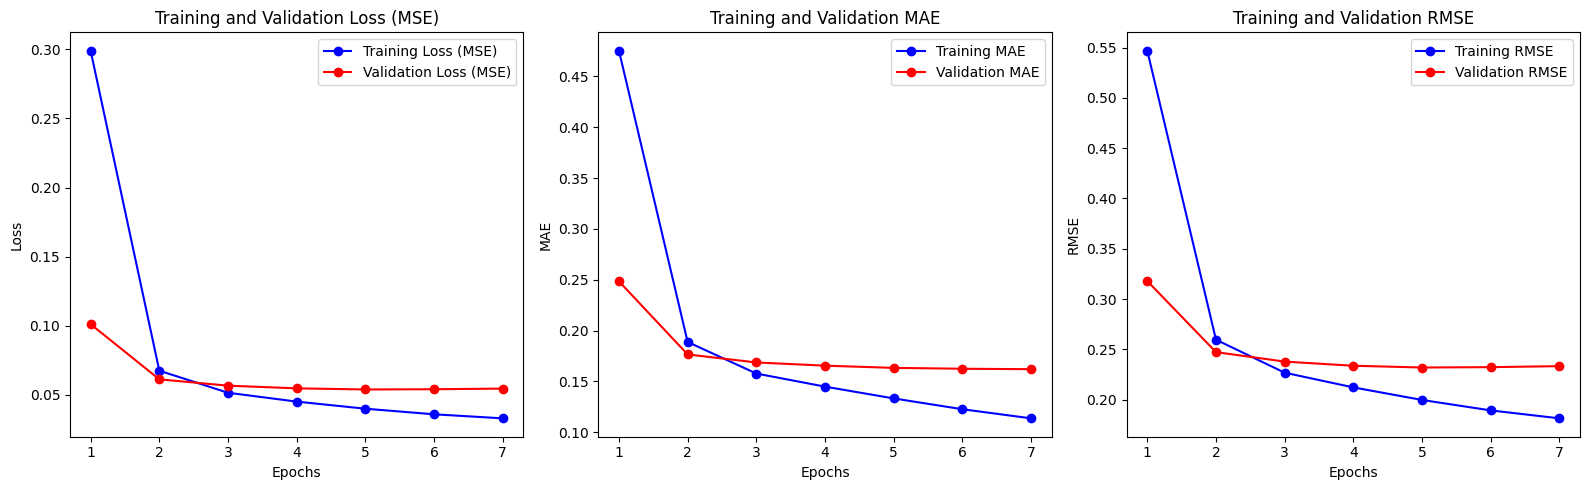

In [66]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mean_absolute_error']
val_mae = history_dict['val_mean_absolute_error']

rmse = np.sqrt(loss)
val_rmse = np.sqrt(val_loss)

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss (MSE)')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss (MSE)')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, rmse, 'bo-', label='Training RMSE')
plt.plot(epochs, val_rmse, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()